# DataSHIELD Python Demo

1. Establish connections with DataSHIELD nodes

In [1]:
from datashield import DSSession, DSLoginBuilder
import pandas as pd
import matplotlib.pyplot as plt

url = "https://opal-demo.obiba.org"
builder = DSLoginBuilder().add("server1", url, "dsuser", "P@ssw0rd").add("server2", url, "dsuser", "P@ssw0rd")
logins = builder.build()

session = DSSession(logins)
session.open()

2. Utility functions

In [ ]:
session.profiles()

In [ ]:
pkgs = session.packages()
pd.DataFrame.from_records(pkgs["server1"])

In [ ]:
methods = session.methods(type="aggregate")
pd.DataFrame.from_records(methods["server1"])

In [ ]:
session.tables()

In [ ]:
session.resources()

3. Make analysis

In [8]:
# Optional: explicitly start R server sessions
rsessions = session.sessions()
print(f"Last message from server1: {rsessions['server1'].get_last_message()}")
print(f"Events from server1: {rsessions['server1'].get_events()}")

Last message from server1: Ready
Events from server1: [['PENDING', '2026-02-17T14:01:01.399Z', 'Created'], ['RUNNING', '2026-02-17T14:01:01.427Z', 'Ready']]


In [61]:
session.assign_resource("client", resources={"server1": "RSRC.CNSIM1", "server2": "RSRC.CNSIM2"})
session.ls()

{'server1': ['client'], 'server2': ['client']}

In [62]:
session.aggregate('classDS("client")')

{'server1': ['SQLResourceClient', 'ResourceClient', 'R6'],
 'server2': ['TidyFileResourceClient',
  'FileResourceClient',
  'ResourceClient',
  'R6']}

In [63]:
session.assign_expr("df", "as.resource.data.frame(client, strict = TRUE)")
session.ls()

{'server1': ['client', 'df'], 'server2': ['client', 'df']}

In [64]:
session.aggregate('classDS("df")')

{'server1': 'data.frame', 'server2': 'data.frame'}

In [65]:
session.aggregate('colnamesDS("df")')

{'server1': ['id',
  'LAB_TSC',
  'LAB_TRIG',
  'LAB_HDL',
  'LAB_GLUC_ADJUSTED',
  'PM_BMI_CONTINUOUS',
  'DIS_CVA',
  'MEDI_LPD',
  'DIS_DIAB',
  'DIS_AMI',
  'GENDER',
  'PM_BMI_CATEGORICAL'],
 'server2': ['entity_id',
  'DIS_AMI',
  'DIS_CVA',
  'DIS_DIAB',
  'GENDER',
  'LAB_GLUC_ADJUSTED',
  'LAB_HDL',
  'LAB_TRIG',
  'LAB_TSC',
  'MEDI_LPD',
  'PM_BMI_CATEGORICAL',
  'PM_BMI_CONTINUOUS']}

In [66]:
session.aggregate("meanDS(df$LAB_GLUC_ADJUSTED)")

{'server1': {'EstimatedMean': 6.12409001097695,
  'Nmissing': 341,
  'Nvalid': 1822,
  'Ntotal': 2163,
  'ValidityMessage': 'VALID ANALYSIS'},
 'server2': {'EstimatedMean': 6.10151761517615,
  'Nmissing': 505,
  'Nvalid': 2583,
  'Ntotal': 3088,
  'ValidityMessage': 'VALID ANALYSIS'}}

In [4]:
session.assign_table("df2", tables={"server1": "CNSIM.CNSIM1", "server2": "CNSIM.CNSIM2"})
session.ls()

{'server1': ['df2'], 'server2': ['df2']}

In [5]:
numints = 20
densityGrid = session.aggregate(
    f"densityGridDS(df2$LAB_TSC, df2$LAB_HDL, limits=FALSE, x.min=NULL, x.max=NULL, y.min=NULL, y.max=NULL, numints = {numints})"
)
# densityGrid["server1"]

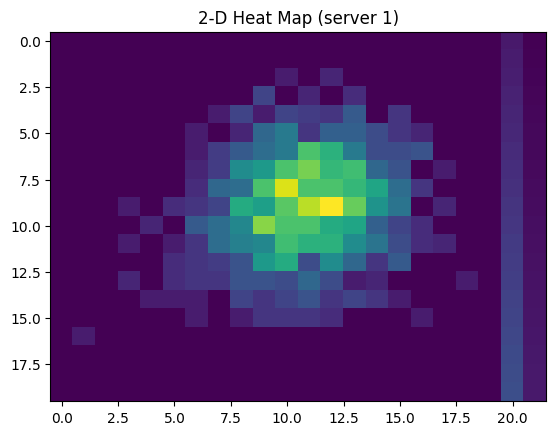

In [ ]:
plt.imshow(densityGrid["server1"], aspect="auto")
plt.title("2-D Heat Map (server 1)")
plt.show()

In [ ]:
data = session.aggregate(
    "histogramDS2(df2$LAB_GLUC_ADJUSTED, num.breaks=20, min=0, max=20, method.indicator=1, k=3, noise=0.25)"
)

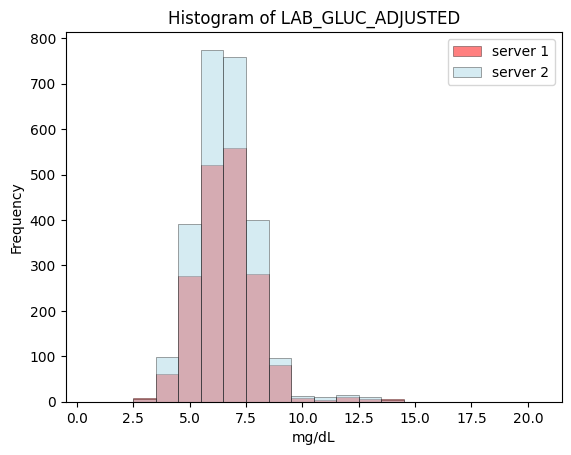

In [8]:
breaks1 = data["server1"]["value"][0]["value"][0]["value"]
counts1 = data["server1"]["value"][0]["value"][1]["value"]
plt.bar(breaks1[1:], counts1, width=1, edgecolor="black", linewidth=0.5, color="red", alpha=0.5, label="server 1")

breaks2 = data["server2"]["value"][0]["value"][0]["value"]
counts2 = data["server2"]["value"][0]["value"][1]["value"]
plt.bar(breaks2[1:], counts2, width=1, edgecolor="black", linewidth=0.5, color="lightblue", alpha=0.5, label="server 2")

plt.xlabel("mg/dL")
plt.ylabel("Frequency")
plt.title("Histogram of LAB_GLUC_ADJUSTED")
plt.legend()
plt.show()

In [9]:
data = session.aggregate("heatmapPlotDS(df2$LAB_TSC, df2$LAB_HDL, 3, 0.25, 1)")

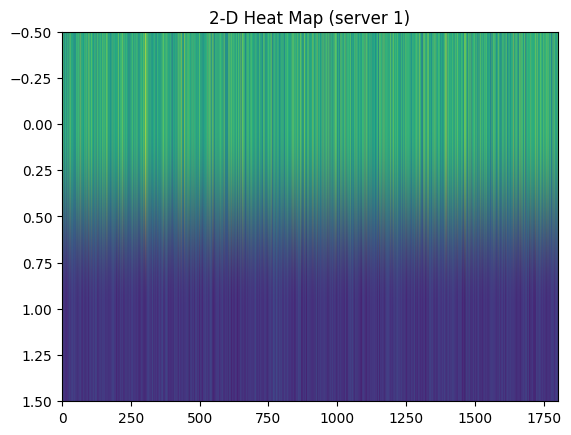

In [29]:
# make heatmap with x and y
plt.imshow(data["server1"], aspect="auto")
plt.title("2-D Heat Map (server 1)")
plt.show()

4. Cleanup

In [40]:
session.close()